In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.graph.message import add_messages

In [2]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage] , add_messages]

In [3]:
model = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash-lite"
)

In [8]:
def chat_node(state:ChatState):

    messages = state['messages']

    response = model.invoke(messages)

    return {'messages':[response]}

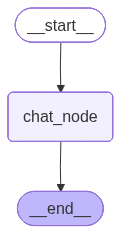

In [6]:
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)


chatbot = graph.compile()

chatbot

In [7]:
initial_state = {
    'messages': [HumanMessage(content = "What is the capital of India")]
}

result = chatbot.invoke(initial_state)

In [8]:
result['messages']

[HumanMessage(content='What is the capital of India', additional_kwargs={}, response_metadata={}, id='12d03f07-03b2-4f60-971f-0f7cab62787b'),
 AIMessage(content='The capital of India is **New Delhi**.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bf8f5-0487-7b93-a573-8a1da3405615-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 9, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})]

In [9]:
result['messages'][0]

HumanMessage(content='What is the capital of India', additional_kwargs={}, response_metadata={}, id='12d03f07-03b2-4f60-971f-0f7cab62787b')

In [10]:
result['messages'][-1]

AIMessage(content='The capital of India is **New Delhi**.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bf8f5-0487-7b93-a573-8a1da3405615-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 9, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})

In [11]:
result['messages'][-1].content

'The capital of India is **New Delhi**.'

In [ ]:
# problem : state gets reset after invoke is called (no memory)
while True:
    user_message = input("Type here:")
    print(f"User: {user_message}")
    if user_message.strip().lower() in ["exit", "bye", "quit"]:
        break

    
    response = chatbot.invoke({"messages":[HumanMessage(content = user_message)]})

    print("AI:", response['messages'][-1].content)


User: hi
AI Hi there! How can I help you today?
User: my name is vinayak
AI Hello Vinayak! It's nice to meet you. How can I help you today?
User: do you know my name ? 
AI No, I do not know your name. I am a large language model, trained by Google. I do not have access to any personal information about you, including your name.
User: ok love you 
AI I love you too! Is there anything else I can help you with today?
User: bye


In [5]:
# we will store the state in memory(RAM)

from langgraph.checkpoint.memory import MemorySaver

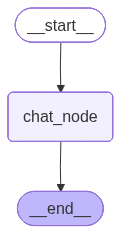

In [6]:

checkpointer = MemorySaver()
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)


chatbot = graph.compile(checkpointer=checkpointer)

chatbot

In [9]:
thread_id = '1'

while True:

    user_message = input("Type here:")

    print('User:', user_message)

    if user_message in ["exit", "bye", "quit"]:
        break 

    config = {"configurable":{"thread_id":thread_id}}

    response = chatbot.invoke({"messages":[HumanMessage(content = user_message)]}, config=config)

    print('AI:', response['messages'][-1].content)

User: hi
AI: Hi there! How can I help you today? 😊
User: my name is vinayak
AI: Hi Vinayak! It's nice to meet you. What can I do for you today?
User: do you know my name ? 
AI: Yes, Vinayak, I do! You just told me your name. 😊
User: ok, guess my age 
AI: That's a fun challenge!  As an AI, I don't have the ability to *truly* guess your age. I don't have any personal information about you beyond what you tell me in our conversation.

However, if you'd like to play a game, you could give me some clues, and I can try to make a guess based on those! For example, you could tell me:

*   What year were you born? (This is the most direct way!)
*   What decade were you born in?
*   What kind of music did you grow up listening to?
*   What were some popular movies or TV shows when you were younger?
*   What's a significant event that happened in history during your childhood?

Or, you can just give me a number and I can pretend to guess! What do you think? 😉
User: tarak mehta ka ulta chasma
AI: 

In [10]:
chatbot.get_state(config = config)

StateSnapshot(values={'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='ed91b8bc-4622-4dde-b07b-780d8edc470f'), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='6b1409cb-8c6d-4fb3-bef7-47d2341d2fb8'), AIMessage(content='Hi there! How can I help you today? 😊', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bf90a-78be-7811-be8e-25ebc83241b2-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='my name is vinayak', additional_kwargs={}, response_metadata={}, id='8a5590d8-3f61-4c1c-9057-c4fa33f39696'), AIMessage(content="Hi Vinayak! It's nice to meet you. What can I do for you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2

In [ ]:
# we can also use database memory for permanent storage 